In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

In [2]:
# print(plt.style.available)
plt.style.use("seaborn-v0_8-deep")
print(plt.colormaps())

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

### Crime Data

#### Importing and Basic Cleaning

In [3]:
# Importing Dataframes
crimes = pd.read_csv(
    "data/crimes_combined.csv",
    index_col=0,
    dtype={
        "beat": "Int64",
        "community_area": str,
        "fbi_code": str,
    },
    low_memory=False,
)
codes = pd.read_csv("data/IUCR_Codes.csv", index_col=0)

In [4]:
# Setting Data Types
crimes['date'] = pd.to_datetime(crimes['date'])
crimes['domestic'] = crimes['domestic'].astype(str).str.lower()
crimes['domestic'] = crimes['domestic'].apply(lambda x: True if x != 'false' else False)

# Sorting by date
crimes.sort_values(by='date', ascending=False, inplace=True)

In [5]:
# Removing leading zeros from IUCR codes because of mistmatch between the two datasets.
codes.index = codes.index.str.lstrip("0")
crimes["iucr"] = crimes["iucr"].str.lstrip("0")

In [6]:
# Joining crimes and IUCR codes datasets
crimes_joined = crimes.join(
    other=codes[["PRIMARY DESCRIPTION", "SECONDARY DESCRIPTION"]], on="iucr", how="left"
)

In [7]:
# The columns 'primary_type' and 'description' are the equivalents of 'PRIMARY DESCRIPTION' and 'SECONDARY DESCRIPTION
# The latter columns have some NaN values where equivalent value is found in the first pair.
# We can just drop those columns

type_equal_mask = crimes_joined["primary_type"] == crimes_joined["PRIMARY DESCRIPTION"]
not_equal = crimes_joined[~type_equal_mask]

not_equal[not_equal["PRIMARY DESCRIPTION"].notnull()]["PRIMARY DESCRIPTION"].unique()

array(['CRIMINAL SEXUAL ASSAULT'], dtype=object)

In [8]:
# Merging duplicated names for primary_type column.

def clean_crime_types(type: str) -> str:
    output = None
    if type == "CRIM SEXUAL ASSAULT":
        output = "CRIMINAL SEXUAL ASSAULT"
    elif type in ["NON - CRIMINAL", "NON-CRIMINAL (SUBJECT SPECIFIED)"]:
        output = "NON-CRIMINAL"
    else:
        output = type
    return output


crimes_joined["primary_type"] = crimes_joined["primary_type"].apply(clean_crime_types)

# There are duplicated names across description column as well but we will ignore these.

In [9]:
# The data for the first few years is very sparse and includes much fewer observations. We can remove these.

print(crimes_joined['date'].dt.year.value_counts().sort_index())
crimes_joined = crimes_joined[crimes_joined['date'].dt.year > 2004]

date
2001       178
2002       102
2003       118
2004       150
2005    170569
2006    448478
2007    437446
2008    427635
2009    393369
2010    371268
2011    352912
2012    337670
2013    311331
2014    416128
2015    527279
2016    530626
2017    730178
2018    548798
2019    353298
2020    395856
2021    416160
2022    474007
2023    334775
2024    223286
Name: count, dtype: int64


#### Exploratory Analysis

In [10]:
for tup in crimes_joined['arrest'].value_counts().items():
    print(f'Number of{" NOT " if tup[0] is False else " "}arrested: {tup[1]:,}')
print("\n")

for tup in crimes_joined['primary_type'].value_counts().items():
    print(f'{tup[0]}: {tup[1]:,}')

Number of NOT arrested: 6,353,463
Number of arrested: 1,847,606


THEFT: 1,784,665
BATTERY: 1,485,021
CRIMINAL DAMAGE: 924,293
NARCOTICS: 616,208
ASSAULT: 574,921
OTHER OFFENSE: 508,678
DECEPTIVE PRACTICE: 470,541
BURGLARY: 416,443
MOTOR VEHICLE THEFT: 412,355
ROBBERY: 314,414
CRIMINAL TRESPASS: 203,605
WEAPONS VIOLATION: 152,296
OFFENSE INVOLVING CHILDREN: 66,275
PUBLIC PEACE VIOLATION: 54,613
PROSTITUTION: 45,900
CRIMINAL SEXUAL ASSAULT: 43,009
SEX OFFENSE: 33,230
INTERFERENCE WITH PUBLIC OFFICER: 25,357
ARSON: 13,882
GAMBLING: 11,278
LIQUOR LAW VIOLATION: 11,203
HOMICIDE: 10,922
STALKING: 6,771
KIDNAPPING: 5,616
INTIMIDATION: 4,826
CONCEALED CARRY LICENSE VIOLATION: 2,339
OBSCENITY: 1,337
NON-CRIMINAL: 454
PUBLIC INDECENCY: 252
HUMAN TRAFFICKING: 184
OTHER NARCOTIC VIOLATION: 171
RITUALISM: 10


Getting counts of cirme types by different months of year creating a metric to determine which crimes show more seasonality.

In [11]:
# Creating pivot table for counts across different types of crimes, 'primary_type'
# We can determine which crime types have the most amount of seasonality by obtaining CV (Coefficient of Variation).
crimes_pivot = crimes_joined.pivot_table(
    index=crimes_joined["date"].dt.month, columns="primary_type", aggfunc="size"
)
crimes_pivot.loc["total"] = crimes_pivot.iloc[:12].sum(axis=0)
crimes_pivot.loc["mean"] = crimes_pivot.iloc[:12].mean(axis=0)
crimes_pivot.loc["cv"] = (crimes_pivot.iloc[:12].std(axis=0) / crimes_pivot.loc["mean"]).round(decimals=2)
# pivot.index.name = 'month'
# pivot.columns.name = None
crimes_pivot.columns = [col.lower() for col in crimes_pivot.columns]

# Sorting crimes by their CV
crimes_t = crimes_pivot.transpose()
crimes_t.index.name = "primary_type"
crimes_t.columns.name = None
crimes_t.sort_values(by="cv", ascending=False, inplace=True)

# To graph the values we get the relative counts (coutns divided by means)
crimes_plot = crimes_t.apply(lambda row: row[:-3] / row["mean"], axis=1)
crimes_plot[["total", "cv"]] = crimes_t[["total", "cv"]]

# Filtering values based on their CV and Total
crimes_plot = crimes_plot[(crimes_plot["cv"] > 0.1) & (crimes_plot["total"] > 100)].drop(columns=["total", "cv"])

Further investigate seasonality by graphing the relative frequency by month.

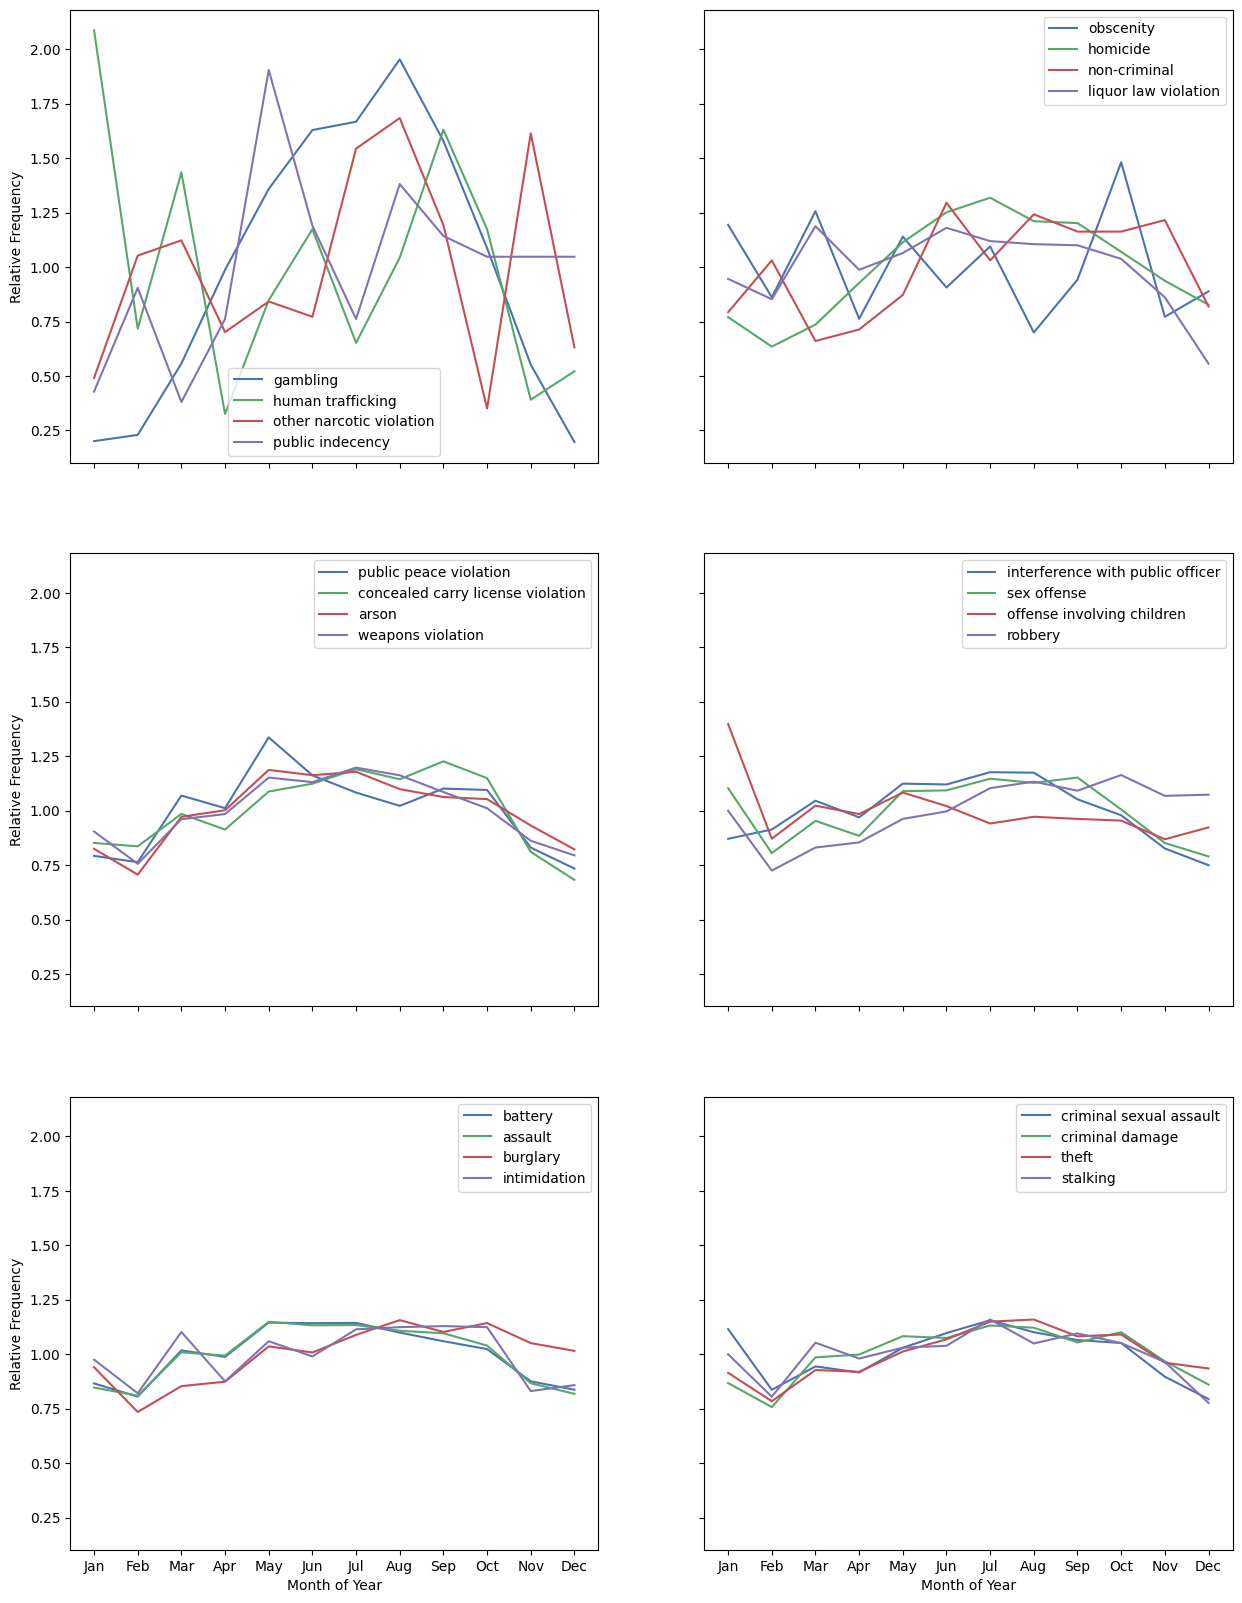

In [12]:
nrows = crimes_plot.shape[0] // 8
ncols = int(crimes_plot.shape[0] / nrows) // 3
step_size = int(crimes_plot.shape[0] / (nrows * ncols))

fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(15, 20))

k = 0
l = 0
for i in range(nrows):
    for j in range(ncols):
        k = k + step_size
        axes[i, j].plot(crimes_plot.iloc[l:k, :].transpose(), label=crimes_plot.index[l:k])
        l = k
        axes[i, j].legend()
        if i == nrows - 1:
            axes[i, j].set_xlabel("Month of Year")
            axes[i, j].set_xticks(ticks = list(crimes_plot.columns), labels= month_names)
        if j == 0:
            axes[i, j].set_ylabel("Relative Frequency")

plt.show()

Here we will see that some crime types show counter-seasonality, we exclude these.
* Offence involving children
* Obsescenity
* Human traficking

In [13]:
# Removing the problematic types from the data index.
crimes_plot.drop(
    labels=["offense involving children", "obscenity", "human trafficking"],
    inplace=True,
)

# Creating a list from remaining indexes.
crime_types = list(crimes_plot.index)

# Filtering original data based on the list of target crime types.
crimes_joined["primary_type"] = crimes_joined["primary_type"].str.lower()
crimes_filtered = crimes_joined[crimes_joined["primary_type"].isin(crime_types)]
# crimes_filtered.reset_index(inplace=True)
crimes_count = crimes_filtered.groupby(crimes_filtered["date"].dt.month).agg("size")
crimes_count.index.name = "month"

### Weather Data: Cleaning and Exploratory Analysis

In [14]:
# Improrting Data
weather = pd.read_csv('data/weather_data.csv', low_memory=False)

In [15]:
# Cleaning column names and data types
weather.columns = [column.lower() for column in weather.columns]
weather['date'] = pd.to_datetime(weather['date'])

# Sorting by date
weather.sort_values(by='date', ascending=False, inplace=True)

In [16]:
# Getting a list of metric columns to be used for grouping and aggregatiion.
metric_columns = weather.columns[:13].drop(['station', 'date', 'name', 'tsun'])

# Since our dataset includes datapoints from two different stations, we need to aggregate.
across_stations = weather.groupby(by='date')[metric_columns].agg('mean')
across_stations.reset_index(inplace=True)

In [17]:
# Further grouping and aggregations to get data across periods "Y-M" as well as monthly.

period = across_stations.groupby(across_stations['date'].dt.to_period('M'))[
    ['awnd', 'fmtm', 'pgtm', 'prcp', 'snow', 'snwd', 'tavg', 'tmax', 'tmin']
]

monthly = across_stations.groupby(across_stations['date'].dt.month)[
    ['awnd', 'fmtm', 'pgtm', 'prcp', 'snow', 'snwd', 'tavg', 'tmax', 'tmin']
]

period_averages = period.agg('mean')
period_totals = period.agg('sum')
monthly_averages = monthly.agg('mean')
monthly_averages.index.name = "month"

Plotting the monthly temperature, wind and precipitation.

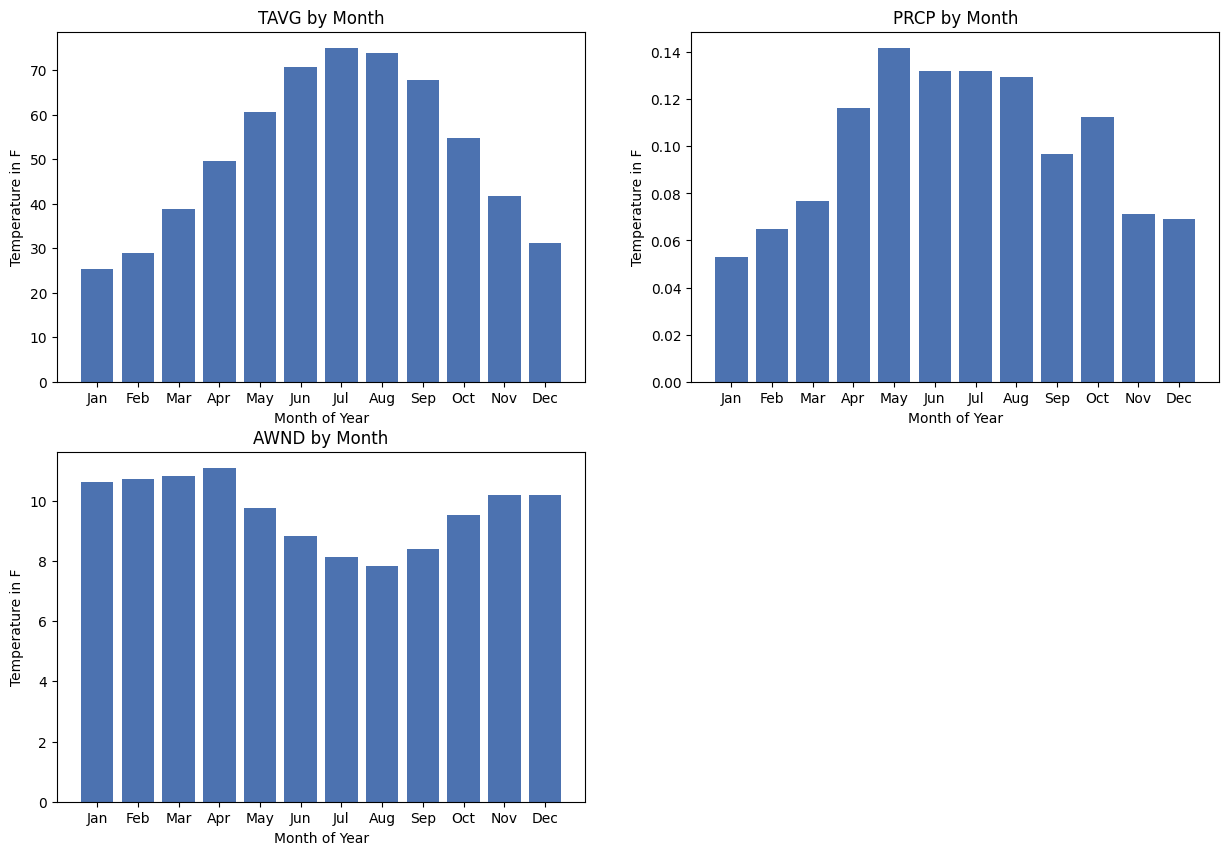

In [18]:
plt.figure(figsize=(15, 10))
fig = plt.gcf()

cols = ["tavg", "prcp", "awnd"]

for i in range(1, 4):
    ax = fig.add_subplot(2, 2, i)
    ax.bar(monthly_averages.index, monthly_averages[cols[i-1]])
    ax.set_title(f"{cols[i-1].upper()} by Month")
    ax.set_ylabel("Temperature in F")
    ax.set_xlabel("Month of Year")
    ax.set_xticks(ticks=monthly_averages.index, labels=month_names)

plt.show()

Concatenating all high-seasonality crimes and plotting them alongside of temperature changes to show the relationships.

### Showing the Research Question Conclusion

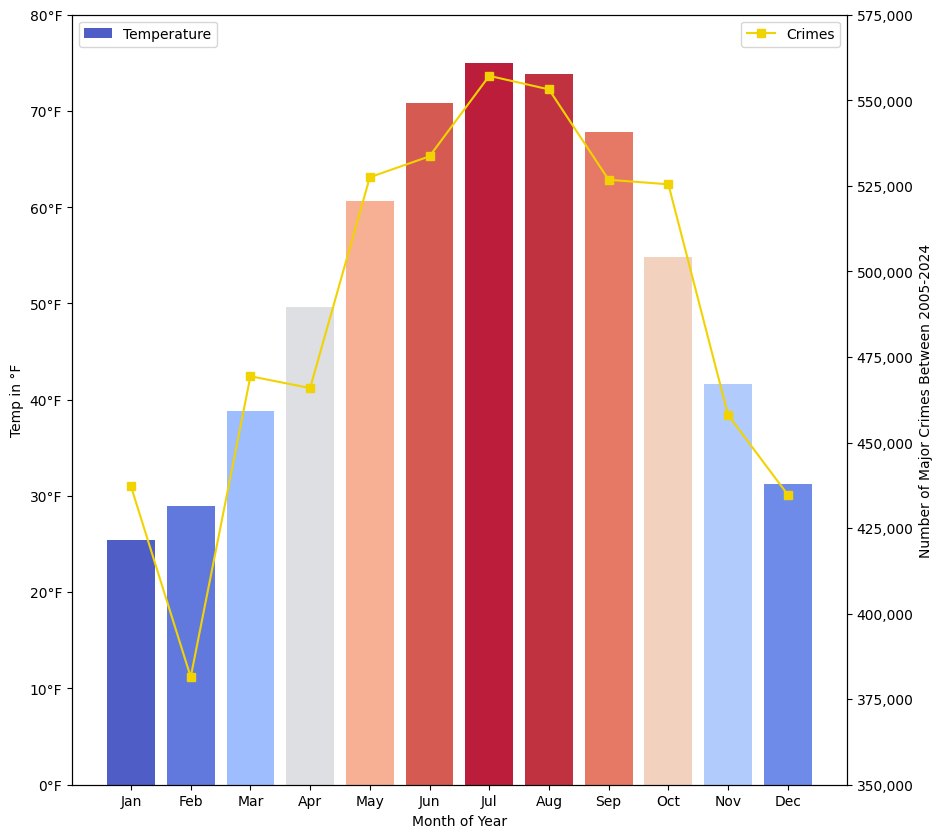

In [40]:
plt.figure(figsize=(10, 10))

ax = plt.gca()

# Normalize temperature data to [0, 1] range
norm = Normalize()

# Map normalized data to a colormap
cmap = plt.colormaps["coolwarm"]
colors = cmap(norm(monthly_averages["tavg"]))

# Plotting and setting plot parameters
ax.bar(
    monthly_averages.index,
    monthly_averages["tavg"],
    color=colors,
    label="Temperature",
    alpha=0.9,
)
ax.set_xlabel("Month of Year")
ax.set_xticks(ticks=monthly_averages.index, labels=month_names)
ax.set_ylabel("Temp in °F")
formatted_temp = [f"{tick:.0f}°F" for tick in ax.get_yticks()]
ax.set_yticks(ticks=ax.get_yticks(), labels=formatted_temp)

# Creating another axis that shared the x axis with the previous graph.
ax2 = ax.twinx()

# Plotting and setting the plot parameters
ax2.plot(crimes_count, "-s", color="#F1D302", label="Crimes")
ax2.set_ylabel("Number of Major Crimes Between 2005-2024")
formatted_freq = [f"{int(tick):,}" for tick in ax2.get_yticks()]
ax2.set_yticks(ticks=ax2.get_yticks(), labels=formatted_freq)

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()